# Montaje

In [1]:
from google.colab import drive, files
import sys

drive.mount('/content/drive', force_remount=True)
# '/content/drive/My Drive/Universidad/Proyectos/NubesKeras'
sys.path.append('/content/drive/My Drive/Proyectos/NubesKeras')

import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd

from tensorflow.keras.models import Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from math import ceil

config = tf.ConfigProto(log_device_placement=False, allow_soft_placement=True)    
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.90
sess = tf.Session(config = config)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Carga de datos

In [2]:
from Model import *
from Utils import *

file_dir = "/content/drive/My Drive/Proyectos/NubesKeras/data"
model_dir = "/content/drive/My Drive/Proyectos/NubesKeras/results"

data = load_data(file_dir)

data_generator = make_data_generator(data['train'])


SMOTE oversampling

Label train set shape: 7932, 12
Label valid set shape: 461, 12
Label test set shape: 923, 12


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni


Image train set shape: 7932, 256, 256, 3
Image valid set shape: 461, 256, 256, 3
Image test set shape: 923, 256, 256, 3


# Aprendizaje pre-builts

#### VGG19

Unpacking train and validation tests
Building the network
Compiling the network
Layers: 30
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
_

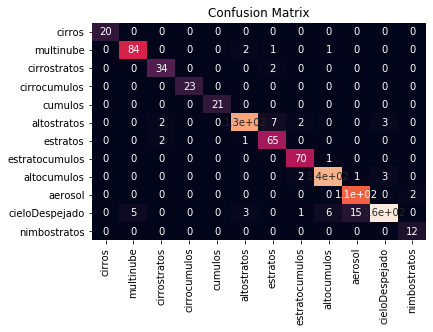

In [0]:
from tensorflow.keras.applications.vgg19 import VGG19
model_name = 'vgg19'
fit_model(data['train'], data['valid'], data_generator,
          make_prebuilt(VGG19, .1),
          batch_size=128,
          model_name=model_name,
          model_dir=model_dir)

save_results(model_dir, model_name, data['label_encoder'],
             data_generator, test_data=data['test'])


Unpacking train and validation tests
Building the network
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
80142336/80134624 [==============================] - 6s 0us/step
Compiling the network
Layers: 34
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
_______________________________________________________

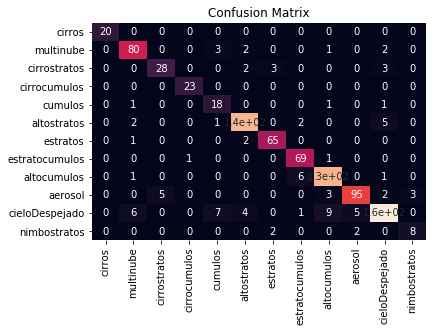

In [0]:
from tensorflow.keras.applications.vgg19 import VGG19
model_name = 'vgg19_alt'
fit_model(data['train'], data['valid'], data_generator,
          make_prebuilt_extended(VGG19, .1), 
          model_name=model_name,
          model_dir=model_dir)

save_results(model_dir, model_name, data['label_encoder'],
             data_generator, test_data=data['test'])


#### Inception V3

Unpacking train and validation tests
Building the network
87916544/87910968 [==============================] - 1s 0us/step
Compiling the network
Layers: 320
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (N

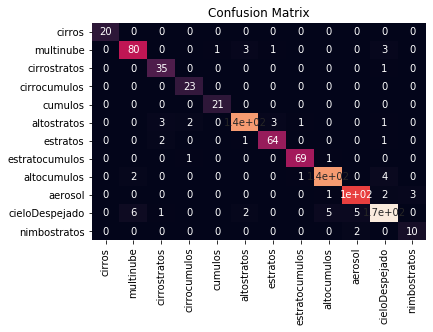

In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
model_name = 'inceptionv3'
fit_model(data['train'], data['valid'], data_generator,
                        make_prebuilt(InceptionV3,.1), model_name=model_name,
                        model_dir=model_dir)

save_results(model_dir, model_name, data['label_encoder'],
             data_generator, test_data=data['test'])

#### Inception ResNet V2

Unpacking train and validation tests
Building the network
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
219062272/219055592 [==============================] - 8s 0us/step
Compiling the network
Layers: 788
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
____________________________________________________

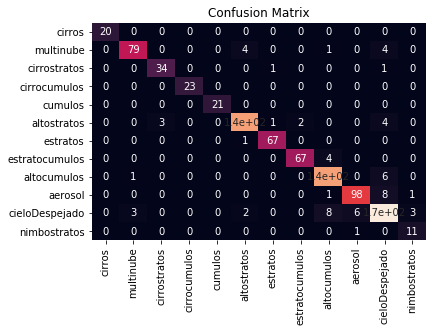

In [0]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
model_name = 'inceptionresnetv2'
fit_model(data['train'], data['valid'], data_generator,
                        make_prebuilt(InceptionResNetV2,.25), model_name=model_name,
                        model_dir=model_dir)
save_results(model_dir, model_name, data['label_encoder'],
             data_generator, test_data=data['test'])

#### NASNetLarge

In [0]:
from tensorflow.keras.applications.nasnet import NASNetLarge
model_name = 'nasnetlarge'
fit_model(data['train'], data['valid'], data_generator,
                        make_prebuilt(NASNetLarge, .5, wgh=None), model_name=model_name,
                        model_dir=model_dir, batch_size=32)
save_results(model_dir, model_name, data['label_encoder'],
             data_generator, test_data=data['test'])

Unpacking train and validation tests
Building the network
Compiling the network
Layers: 1047
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 127, 127, 96) 2592        input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 127, 127, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 127, 127, 96) 0           stem_bn1[0][0]                   

# Random Forest Ensembles

##### NN into RF

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864  

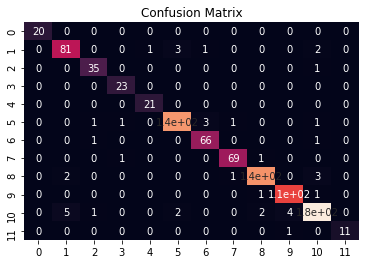

In [0]:
model_name = 'inceptionv3'
model = load_model('%s/%s' % (model_dir, '%s_model.h5' % model_name))
model.summary()

# Training rf
print('Train')
x_train = data['features'][0]
y_train = data['label_encoder'].inverse_transform(data['train'][-1])

print('tr - Train classifier')
classifier = RandomForestClassifier(250, random_state=1,
                                    max_features=.35)

classifier.fit(x_train, y_train)

print('Test')
img_test, ceil_test, y_test= data['test']
x_test = data['features'][-1]
standard_img_test = data_generator.standardize(img_test)

print('te - Get predictions from trained model')
nn_pred = model.predict([standard_img_test, ceil_test])
rf_pred = classifier.predict_proba(x_test)
avg_pred = (nn_pred + rf_pred)/2
max_pred = np.maximum(nn_pred, rf_pred)

rf_pred = data['label_encoder'].inverse_transform(rf_pred)
nn_pred = data['label_encoder'].inverse_transform(nn_pred)
avg_pred = data['label_encoder'].inverse_transform(avg_pred)
max_pred = data['label_encoder'].inverse_transform(max_pred)

decoded_observations = data['label_encoder'].inverse_transform(y_test)
pred_obs = pd.DataFrame(data={'avg_pred': avg_pred,
                              'max_pred': max_pred,
                              'obs': decoded_observations,
                              'rf_pred': rf_pred,
                              'nn_pred': nn_pred})


print('---{}---'.format('ensemble_avg'))
print(classification_report(pred_obs['obs'], pred_obs['avg_pred'], digits=4))
print('---{}---'.format('ensemble_max'))
print(classification_report(pred_obs['obs'], pred_obs['max_pred'], digits=4))
print('---{}---'.format('random_forest'))
print(classification_report(pred_obs['obs'], pred_obs['rf_pred'], digits=4))
print('---{}---'.format(model_name))
print(classification_report(pred_obs['obs'], pred_obs['nn_pred'], digits=4))

# Evaluar el Modelo
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
matrix = confusion_matrix(pred_obs['obs'], pred_obs['avg_pred'])
#names = pred_obs['obs'].unique()
sns.heatmap(matrix, annot=True, cbar=False)

ensemble_name='inceptionresnetv2_plus_RandomForest'
pred_obs.to_csv('%s/%s' % (file_dir, '%s_preds.csv' % ensemble_name))



#### NN and RF

In [0]:
model_name = 'inceptionresnetv2'
model = load_model('%s/%s' % (model_dir, '%s_model.h5' % model_name))
  
rf_model = Model(inputs=model.input, outputs=model.layers[-5].output)
rf_model.summary()

# Training rf
print('Train')
img_train, ceil_train, y_train = data['train']
print('tr - Get predictions from trained model')
_, att = rf_model.output.shape
num = img_train.shape[0]
batch_size = 128

#train_prediction_set = rf_model.predict_generator(data_generator.flow(x=(img_train,ceil_train),
#                                                                        batch_size=batch_size),
#                                                                        steps= ceil(num/batch_size),
#                                                                        verbose=1)
y_train_dec = list(data['label_encoder'].inverse_transform(y_train))

reductor = PCA(.95, svd_solver='full')
classifier = RandomForestClassifier(100, random_state=1,
                                    max_features=.35, n_jobs=8)

print('tr - Dimensionality reduction')
x = reductor.fit_transform(train_prediction_set)
print(x.shape)

print('tr - Train classifier')
classifier.fit(x, y_train_dec)
decoded_predictions = classifier.predict(x)
pred_obs = pd.DataFrame(data={'pred': decoded_predictions, 'obs': y_train_dec})

print(classification_report(pred_obs['obs'], pred_obs['pred']))

# Testing rf and saving results
print('Test')
img_test, ceil_test, y_test= data['test']
print('te - Standarize test data')
standard_img_test = data_generator.standardize(img_test)
print('te - Get predictions from trained model')
test_predictions = rf_model.predict([standard_img_test, ceil_test])
test_predictions = reductor.transform(test_predictions)
print('te - Final predictions')
decoded_predictions = classifier.predict(test_predictions)
decoded_observations = data['label_encoder'].inverse_transform(y_test)
pred_obs = pd.DataFrame(data={'pred': decoded_predictions, 'obs': decoded_observations})

# Evaluar el Modelo
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

matrix = confusion_matrix(pred_obs['obs'], pred_obs['pred'])
names = pred_obs['obs'].unique()

sns.heatmap(matrix, annot=True, cbar=False, xticklabels=names, yticklabels=names)
print(classification_report(pred_obs['obs'], pred_obs['pred']))

# Almacenar las predicciones del modelo entrenado
# pred_obs.to_csv('%s/%s' % (file_dir, '%s_preds.csv' % model_name))

KeyboardInterrupt: ignored

# Aprendizaje Cropnet

#### CropNet v1






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Layers: 86
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
cropping2d_1 (Cropping2D)       (None, 160, 160, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
cropping2d_2 (Cropping2D)       (None, 160, 160, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
cropping2d_3 (Cropping2D)       (None, 160, 160, 3)  0    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                precision    recall  f1-score   support

       aerosol       0.00      0.00      0.00        20
   altocumulos       0.00      0.00      0.00        88
   altostratos       0.00      0.00      0.00        36
cieloDespejado       0.00      0.00      0.00        23
  cirrocumulos       0.00      0.00      0.00        21
        cirros       0.00      0.00      0.00       145
  cirrostratos       0.00      0.00      0.00        68
       cumulos       0.00      0.00      0.00        71
estratocumulos       0.00      0.00      0.00       142
      estratos       0.00      0.00      0.00       108
     multinube       0.20      1.00      0.34       189
  nimbostratos       0.00      0.00      0.00        12

      accuracy                           0.20       923
     macro avg       0.02      0.08      0.03       923
  weighted avg       0.04      0.20      0.07       923



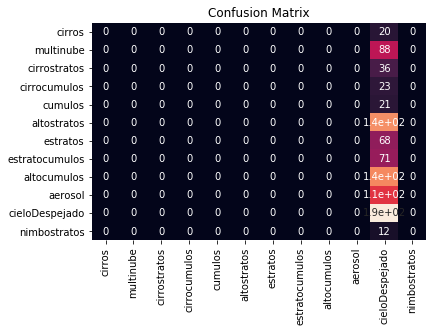

In [0]:
model_name = 'cropnetv1'
fit_model(data['train'], data['valid'], data_generator,
                        make_cropnetv1, model_name=model_name,
                        model_dir=model_dir, lr=1e-3)
save_results(model_dir, model_name, data['label_encoder'],
             data_generator, test_data=data['test'])

#### CropNet v2

Layers: 116
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
cropping2d_5 (Cropping2D)       (None, 160, 160, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
cropping2d_6 (Cropping2D)       (None, 160, 160, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
cropping2d_7 (Cropping2D)       (None, 160, 160, 3)  0           input_4[0][0]                    
________________________________________________________________________________

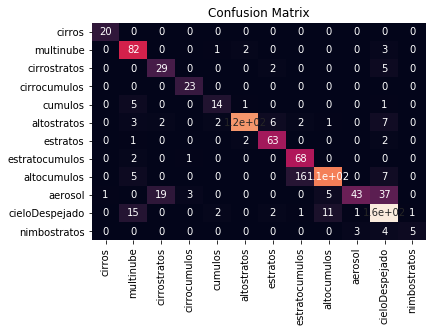

In [0]:
model_name = 'cropnetv2'
fit_model(data['train'], data['valid'], data_generator,
                        make_cropnetv2, model_name=model_name,
                        model_dir=model_dir, n_outputs=6)
save_results(model_dir, model_name, data['label_encoder'],
             data_generator, test_data=data['test'], n_outputs=6)

#### Cropnet v3

Unpacking train and validation tests
Building the network
Compiling the network
Layers: 362
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
cropping2d_4 (Cropping2D)       (None, 160, 160, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
cropping2d_5 (Cropping2D)       (None, 160, 160, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
cropping2d_6 (Cropping2D)       (None, 160, 160, 3)  0           input_12[0][0]                   


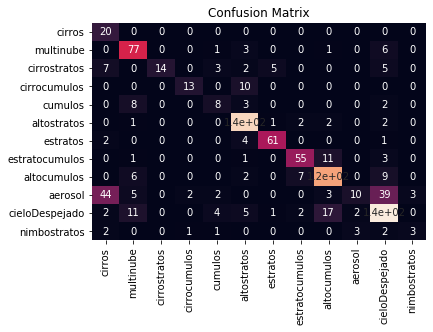

In [0]:

model_name = 'cropnetv3'
fit_model(data['train'], data['valid'], data_generator,
                        make_cropnetv3, model_name=model_name,
                        model_dir=model_dir, n_outputs=6, batch_size=32)
save_results(model_dir, model_name, data['label_encoder'],
             data_generator, test_data=data['test'], n_outputs=6)

#### RandomCropnet v1

In [0]:
model_name = 'rcropnetv1'
fit_model(data['train'], data['valid'], data_generator,
                        make_rcropnetv1(16), model_name=model_name,
                        model_dir=model_dir, n_outputs=18, batch_size=32)
save_results(model_dir, model_name, data['label_encoder'],
             data_generator, test_data=data['test'], n_outputs=18)

Unpacking train and validation tests
Building the network
Compiling the network
Layers: 365
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_338 ( [(None, None, None,  0           input_14[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_strided_slice_341 ( [(None, None, None,  0           input_14[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_strided_slice_344 ( [(None, None, None,  0           input_14[0][0]                   


#### RandomCropnet v2

In [0]:
model_name = 'rcropnetv2'
fit_model(data['train'], data['valid'], data_generator,
                        make_rcropnetv2(32, 128), model_name=model_name,
                        model_dir=model_dir, n_outputs=32+2, batch_size=32)
save_results(model_dir, model_name, data['label_encoder'],
             data_generator, test_data=data['test'], n_outputs=18)

Unpacking train and validation tests
Building the network
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1:0
Compiling the network
Layers: 60
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 256, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_12[0][0]          